# Import

In [21]:
import sqlite3

import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns

from helper.helper import Helper
from config import constants

In [22]:
%matplotlib inline

In [3]:
# disable division by zero warning
np.seterr(divide='ignore', invalid='ignore')

# disabling max open windows warning in matplotlib
matplotlib.rcParams.update({'figure.max_open_warning': 0})

# deactivate SettingWithCopyWarning:
pd.options.mode.chained_assignment = None

# Read raw data file

In [4]:
df = pd.read_excel(constants.SOURCE_FILE, sheet_name=constants.XLSX_SHEET)

# Preparation

In [5]:
# calculate humidity
df['humidity'] = df.apply(func=Helper.calculate_relative_humidity_jupyter, axis=1)
# drop rows with null ids
df.dropna(subset=['store_nbr', 'station_nbr', 'item_nbr'], inplace=True)
# delete lines where units greather than 0
df_only_with_units_nn = df[df['units'] > 0]
# create new df with only relevant columns
relevant_columns = ['date', 'item_nbr', 'station_nbr', 'store_nbr', 'units', 'tmin', 'tmax', 'tavg', 'wetbulb', 'dewpoint', 'snowfall', 'preciptotal', 'avgspeed']
df_new = df_only_with_units_nn[relevant_columns]

# Fetch Store and Item IDs

In [6]:
stores = df_new['store_nbr'].unique()
items = df_new['item_nbr'].unique()
dates = df_new['date'].unique()

# Detect significant Attributes with Multiple Regression

In [ ]:
#fetch all rows from item per store
significant_columns = []

for store_id in stores:
    for item_id in items:
        df_reg = df_new[(df_new['store_nbr'] == store_id) & (df_new['item_nbr'] == item_id)]
        if df_reg.shape[0] > 0:
            df_reg.fillna(0, inplace=True)
            feature_columns = ['snowfall', 'preciptotal', 'tavg', 'tmin', 'tmax', 'humidity', 'avgspeed']
            x = df_reg[feature_columns]
            y = df_reg[['units']]
            # x = sm.add_constant(x)
            model = sm.OLS(y, x).fit()
            p_values = model.pvalues
            for column in feature_columns:
                p_value = float(p_values[column])
                if (not np.isnan(p_value)) and (p_value < constants.SIGNIFICANT_LIMIT):
                    summary = (store_id, item_id, column, p_value, model)
                    significant_columns.append(summary)

# Checking R2 Adjusted

In [ ]:
for summary_tuple in significant_columns:
    column_model = summary_tuple[4]
    column_name = summary_tuple[2]
    print(column_model.rsquared_adj)

# Plotting Regression Plots

In [ ]:
for summary_tuple in significant_columns:
    column_model = summary_tuple[4]
    column_name = summary_tuple[2]
    fig = plt.figure(figsize=(15,8))
    fig = sm.graphics.plot_regress_exog(column_model, column_name, fig=fig)

# Correlation instead of regression

In [ ]:
high_correlation = []

for store_id in stores:
    for item_id in items:
        df_reg = df_new[(df_new['store_nbr'] == store_id) & (df_new['item_nbr'] == item_id)]
        if df_reg.shape[0] > 0:
            df_reg.fillna(0, inplace=True)
            feature_columns = ['snowfall', 'preciptotal', 'tavg', 'tmin', 'tmax', 'humidity', 'avgspeed', 'units']
            corr_df = df_reg[feature_columns]
            corr = corr_df.corr(method='spearman')
            for a in feature_columns:
                for b in feature_columns:
                    if (a == 'units') or (b == 'units'):
                        correlation_value = corr[a][b]
                        if (not np.isnan(correlation_value)) and (abs(correlation_value) > constants.HIGH_CORRELATION) and (abs(correlation_value) != 1):
                            summary_tuple = (store_id, item_id, a, b, correlation_value, corr)
                            high_correlation.append(summary_tuple)

# Plotting correlation with Heatmap

In [ ]:
for correlation_tuple in high_correlation:
    corr = correlation_tuple[5]
    fig, ax = plt.subplots(figsize=(5, 5))
    mappable = ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=60);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(mappable)

# Plotting correlation with Scatter

In [ ]:
for correlation_tuple in high_correlation:
    store_id = correlation_tuple[0]
    item_id = correlation_tuple[1]
    column_a = correlation_tuple[2]
    column_b = correlation_tuple[3]
    corr_value = correlation_tuple[4]
    print(store_id, item_id, column_a, column_b, corr_value)
    df_corr = df_new[(df_new['store_nbr'] == store_id) & (df_new['item_nbr'] == item_id)]
    if column_a == 'units':
        x = df_corr[column_b]
        y = df_corr[column_a]
    else:
        x = df_corr[column_a]
        y = df_corr[column_b]
    plt.scatter(x, y)
    plt.show()

# Plotting sales trends for weather columns - Items/Store

In [ ]:
feature_columns = ['date', 'units']
holidays = ['1/2/2012', '1/16/2012']
for store_id in stores:
    for item_id in items:
        trend_df = df[(df['store_nbr'] == store_id) & (df['item_nbr'] == item_id)]
        trend_df = trend_df[feature_columns]
        if trend_df.shape[0] > 0:
            if (trend_df['units'] == 0).all() == False:
                trend_df.fillna(0, inplace=True)
                trend_df['date'] =  pd.to_datetime(trend_df['date'], format='%m/%d/%Y')
                
                # moving average
                trend_df['units'] = trend_df['units'].rolling(window=5).mean()
                trend_df.dropna(inplace=True)
                
                trend_df.rename(index=str, columns={"date": "day"}, inplace=True)
                trend_df.set_index('day', inplace=True)
                y_label = 'Item ' + str(int(item_id)) + ' in Store ' + str(int(store_id))
                plt.ylabel(y_label)
                plt.grid(True)
                ax = trend_df['units'].plot()
                ticklabels = trend_df.index.strftime('%d')
                ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
                plt.show()

# Plotting sales trends for weather columns - Items

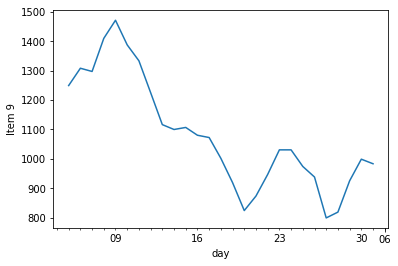

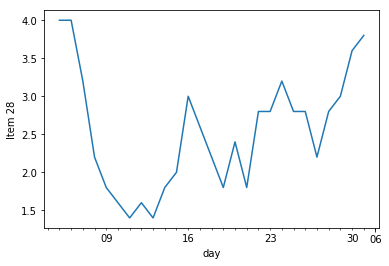

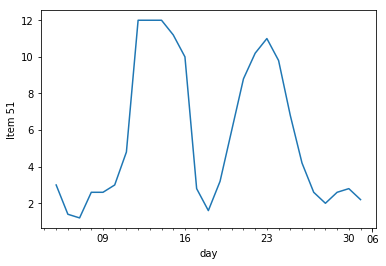

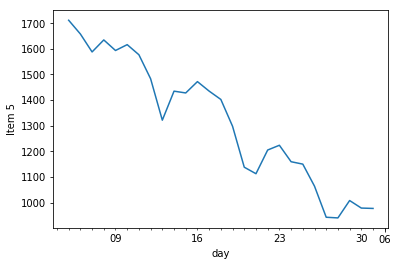

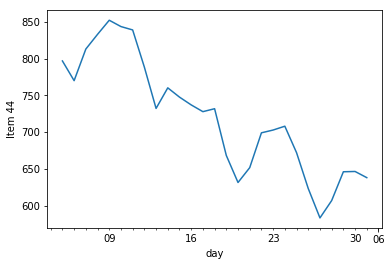

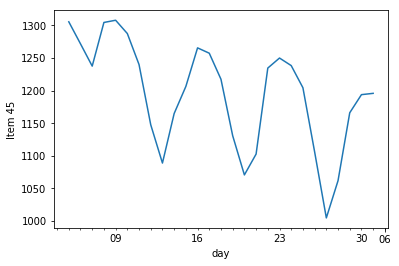

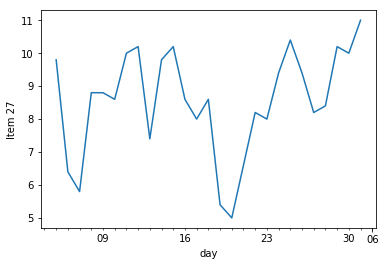

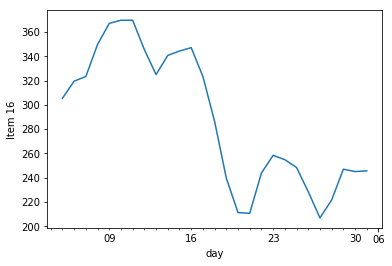

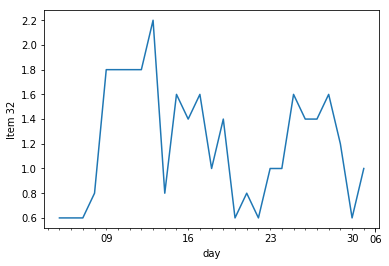

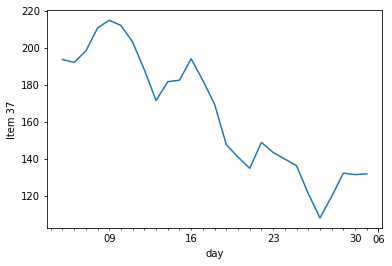

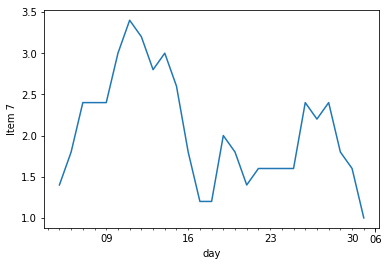

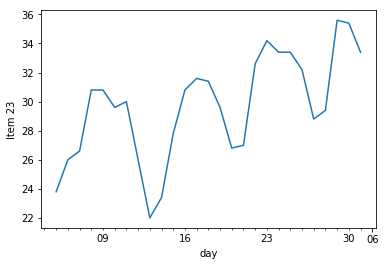

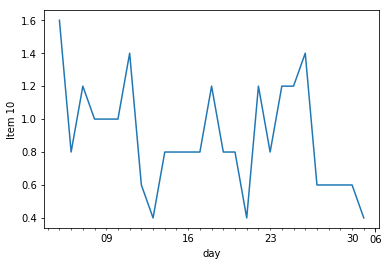

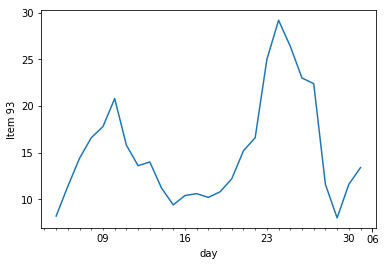

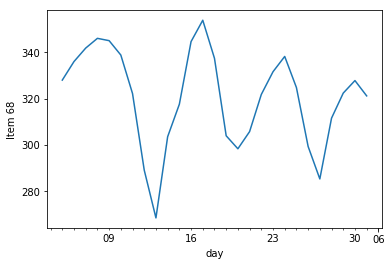

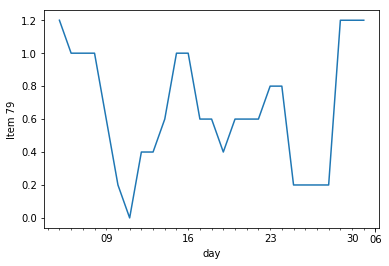

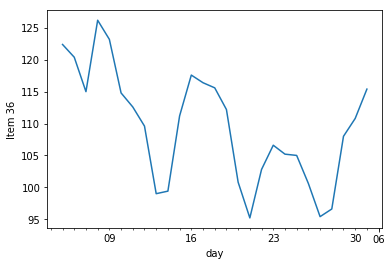

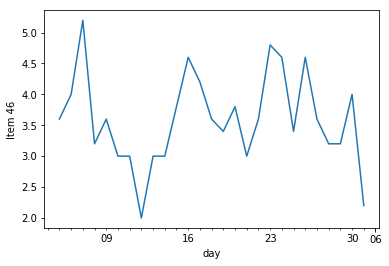

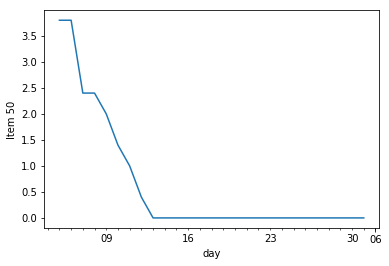

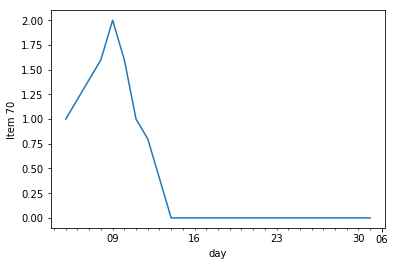

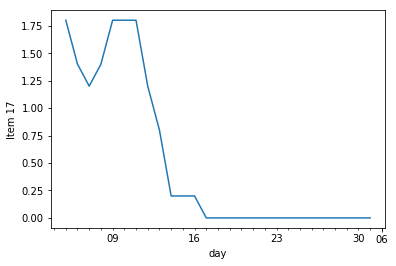

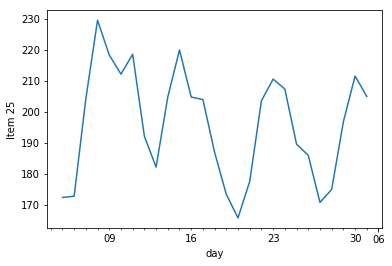

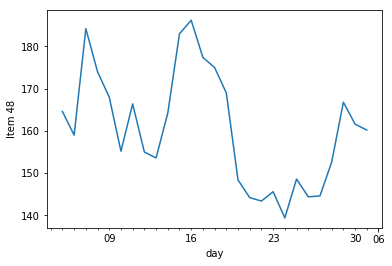

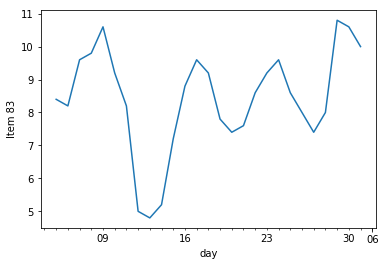

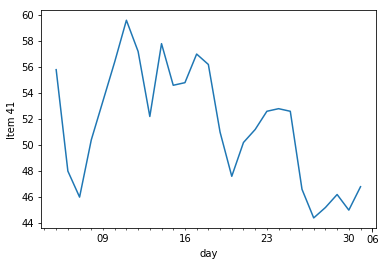

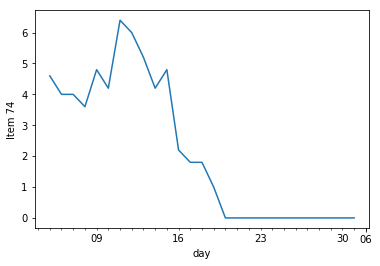

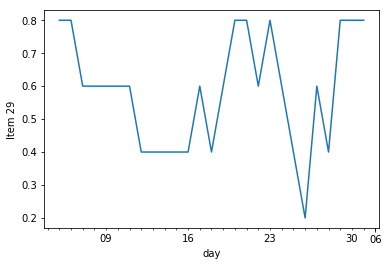

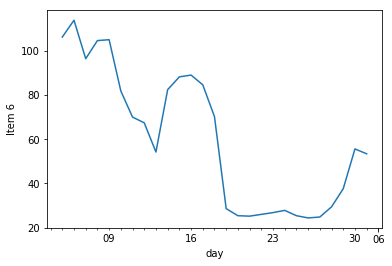

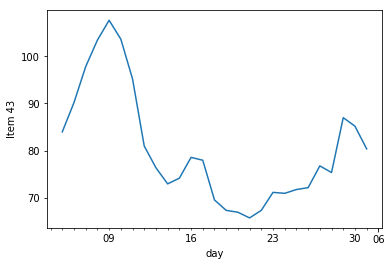

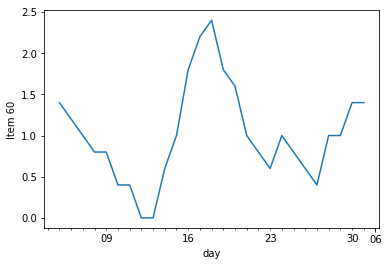

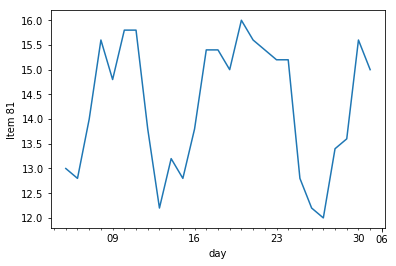

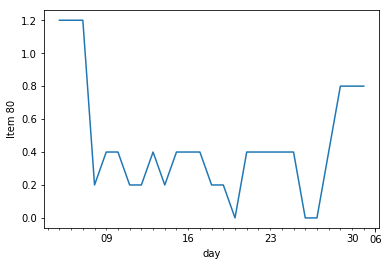

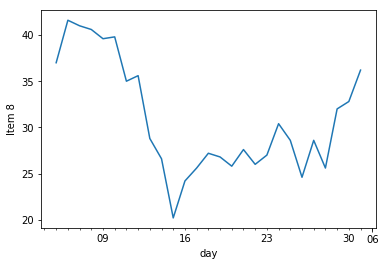

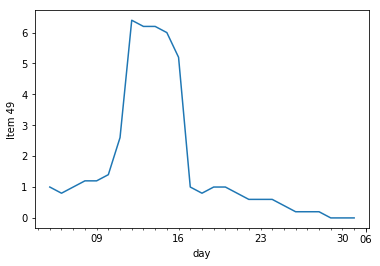

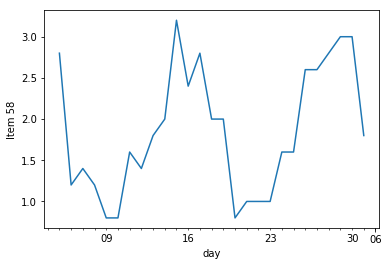

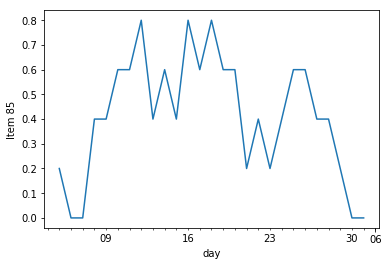

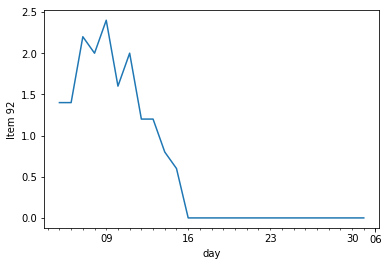

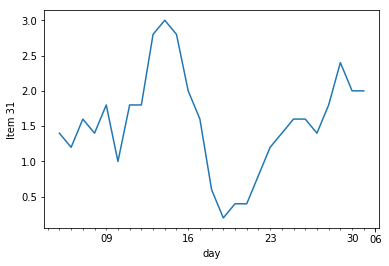

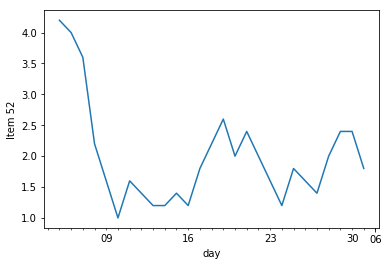

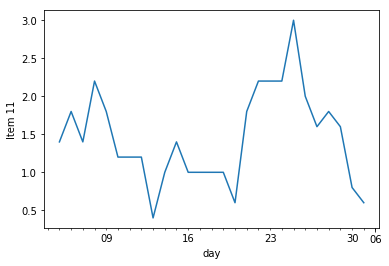

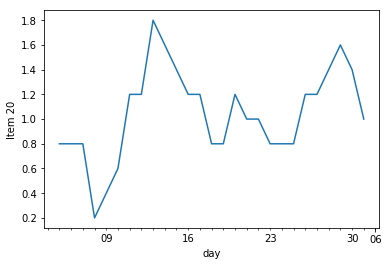

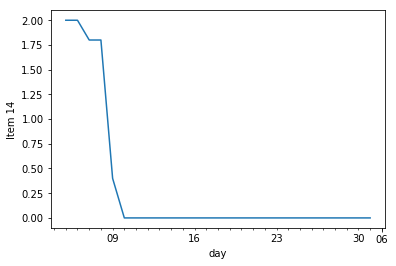

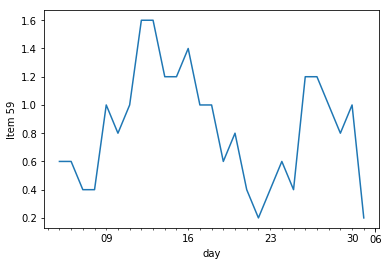

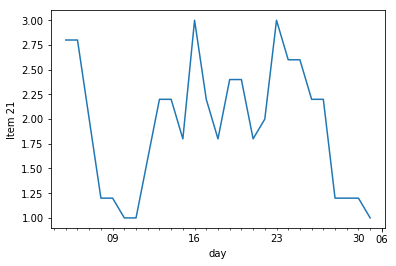

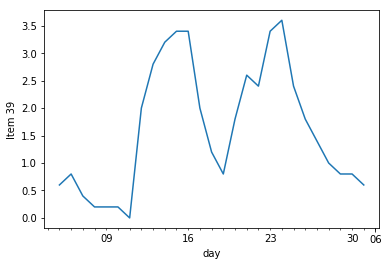

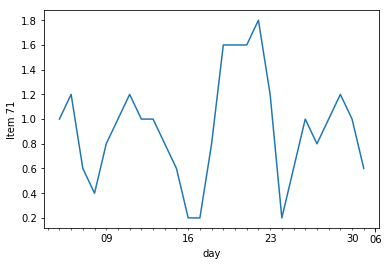

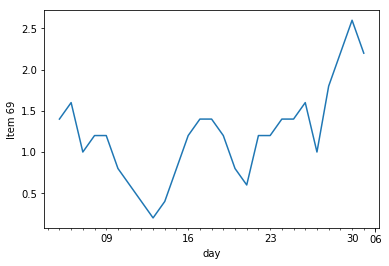

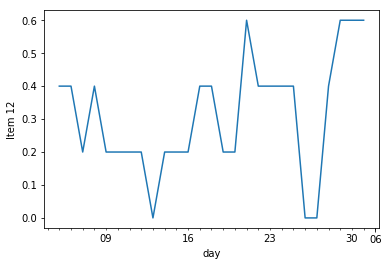

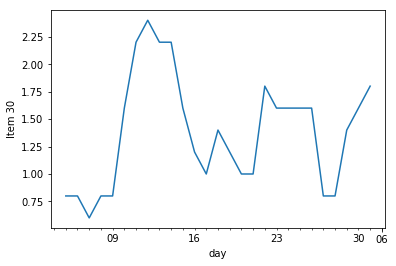

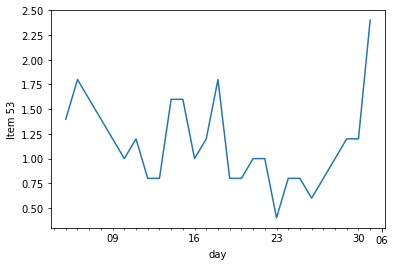

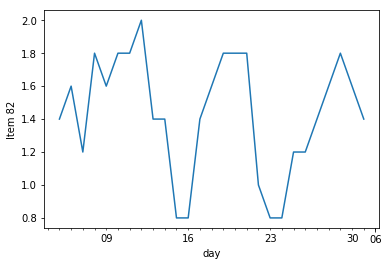

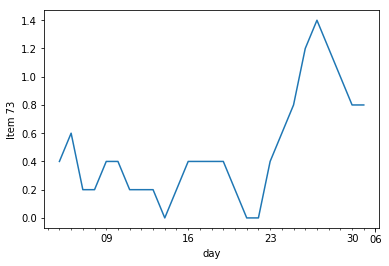

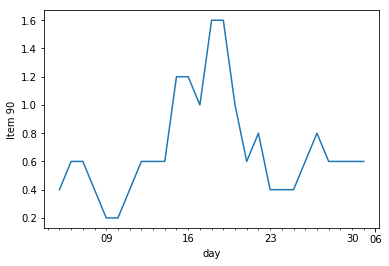

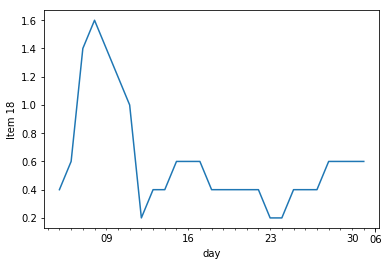

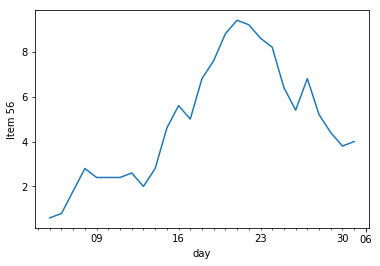

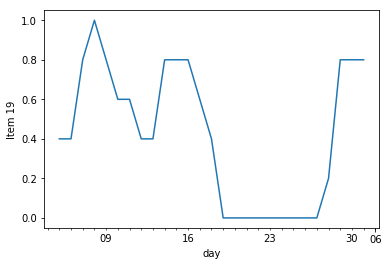

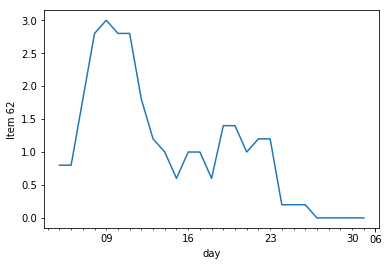

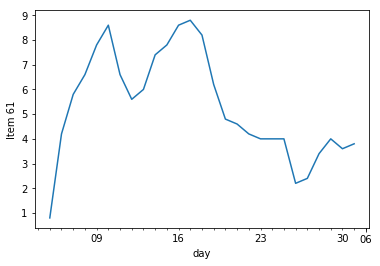

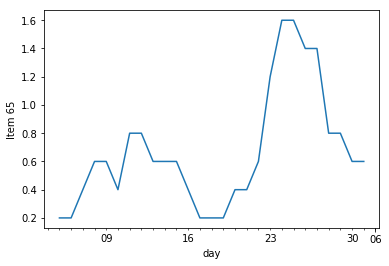

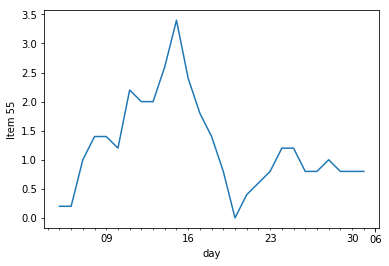

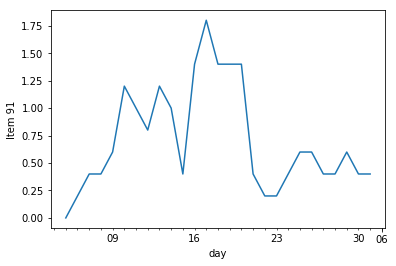

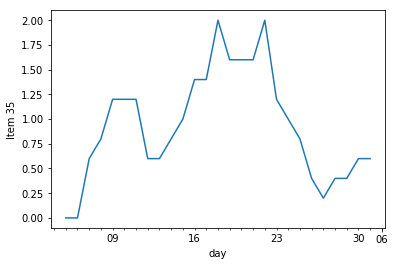

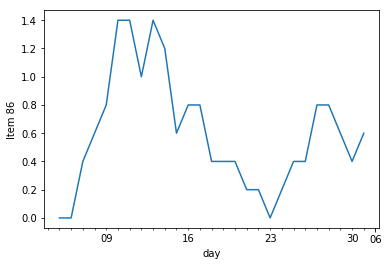

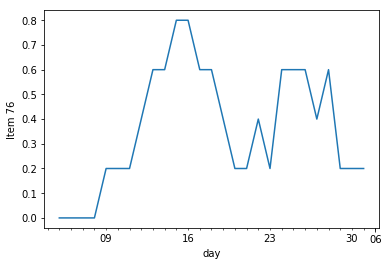

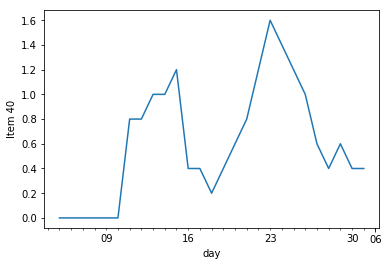

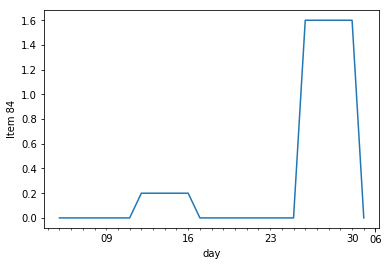

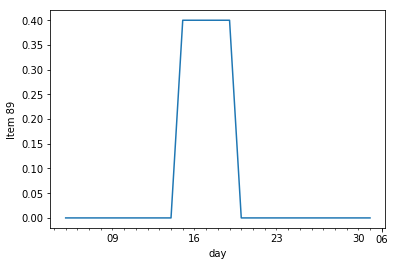

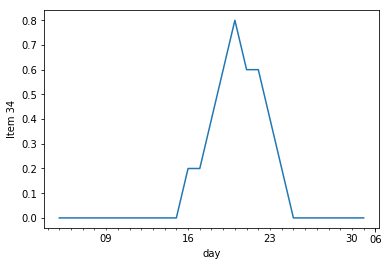

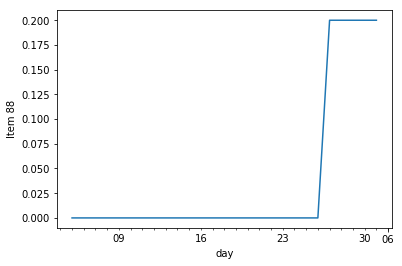

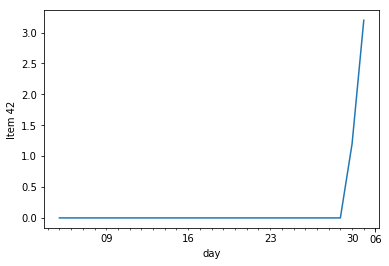

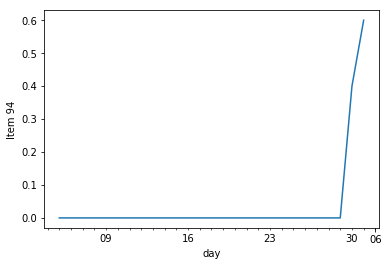

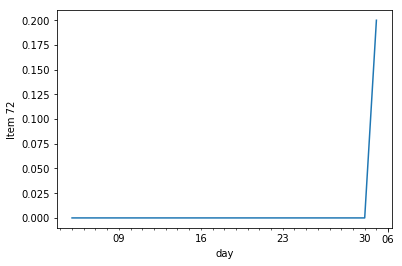

In [56]:
feature_columns = ['date', 'units']
holidays = ['1/2/2012', '1/16/2012']
for item_id in items:
    trend_df = df[df['item_nbr'] == item_id]
    trend_df = trend_df[feature_columns]
    if trend_df.shape[0] > 0:
        if (trend_df['units'] == 0).all() == False:
            trend_df.fillna(0, inplace=True)
            trend_df.rename(index=str, columns={"date": "day"}, inplace=True)
            trend_df['day'] =  pd.to_datetime(trend_df['day'], format='%m/%d/%Y')
            trend_series = trend_df.groupby('day')['units'].agg('sum')
            trend_df = trend_series.to_frame()
            
            # moving average
            trend_df['units'] = trend_df['units'].rolling(window=5).mean()
            trend_df.dropna(inplace=True)
            
            y_label = 'Item ' + str(int(item_id))
            plt.ylabel(y_label)
            plt.grid(True)
            ax = trend_df['units'].plot()
            ticklabels = trend_df.index.strftime('%d')
            ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
            plt.show()